# LSTM

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

## TEXT PRE-PROCESSING FOR NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [7]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import the dataset.**

In [3]:
data=pd.read_csv('/content/drive/MyDrive/new_dataset.csv')
print(data.head())

  sentiment                                               text
0  Negative  @xnausikaax oh no! where did u order from? tha...
1  Negative  A great hard training weekend is over.  a coup...
2  Negative  Right, off to work  Only 5 hours to go until I...
3  Negative                    I am craving for japanese food 
4  Negative  Jean Michel Jarre concert tomorrow  gotta work...


In [7]:
print(data.shape)

(10000, 2)


In [8]:
print(data.tail())

     sentiment                                               text
9995  Positive                   @krystynchong Love to see that! 
9996  Positive    Lovely day spent with the misses. Just loverly 
9997  Positive  @jason_mraz i love the fact that people are es...
9998  Positive  time to shower and tidy then going to go out f...
9999  Positive   @martyndarkly And it's an excuse to get a Wii.  


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving new_dataset.csv to new_dataset.csv


**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


In [9]:
!pip install pandas nltk



In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

data['text'] = data['text'].apply(remove_stopwords)

In [12]:
print(data.head())

  sentiment                                               text
0  Negative            @ xnausikaax oh ! u order ? 's horrible
1  Negative  great hard training weekend . couple days rest...
2  Negative                 Right , work 5 hours go 'm free xD
3  Negative                              craving japanese food
4  Negative  Jean Michel Jarre concert tomorrow got ta work...


**Next, we'll remove some other info we dont need right now, like the handle names.**

In [13]:
import re
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'@\w+', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

In [16]:
print(data.head())
print(data.tail())

  sentiment                                               text
0  Negative            @ xnausikaax oh ! u order ? 's horrible
1  Negative  great hard training weekend . couple days rest...
2  Negative                 Right , work 5 hours go 'm free xD
3  Negative                              craving japanese food
4  Negative  Jean Michel Jarre concert tomorrow got ta work...
     sentiment                                               text
9995  Positive                          @ krystynchong Love see !
9996  Positive                  Lovely day spent misses . loverly
9997  Positive  @ jason_mraz love fact people essentially good...
9998  Positive  time shower tidy going go lunch friend lake si...
9999  Positive                 @ martyndarkly 's excuse get Wii .


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [17]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()


def clean_text_stem(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        stemmed_words = [stemmer.stem(word) for word in words]
        return ' '.join(stemmed_words)
    return ''
data['text'] = data['text'].apply(clean_text_stem)

In [18]:
print(data.head())

  sentiment                                               text
0  Negative             @ xnausikaax oh ! u order ? 's horribl
1  Negative  great hard train weekend . coupl day rest let ...
2  Negative                  right , work 5 hour go 'm free xd
3  Negative                                 crave japanes food
4  Negative  jean michel jarr concert tomorrow got ta work ...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

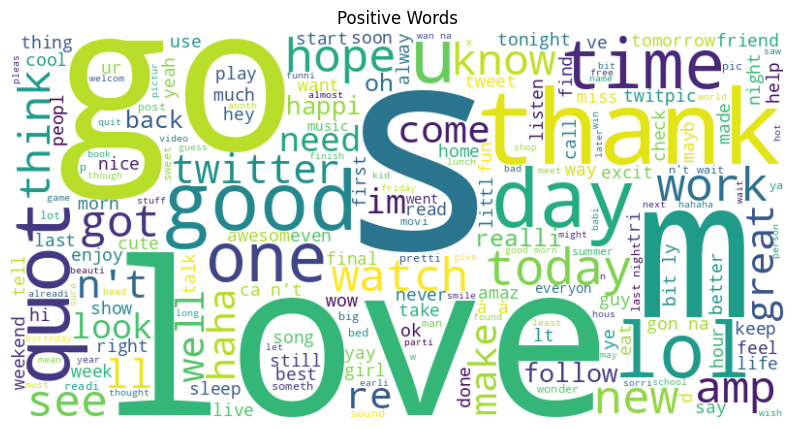

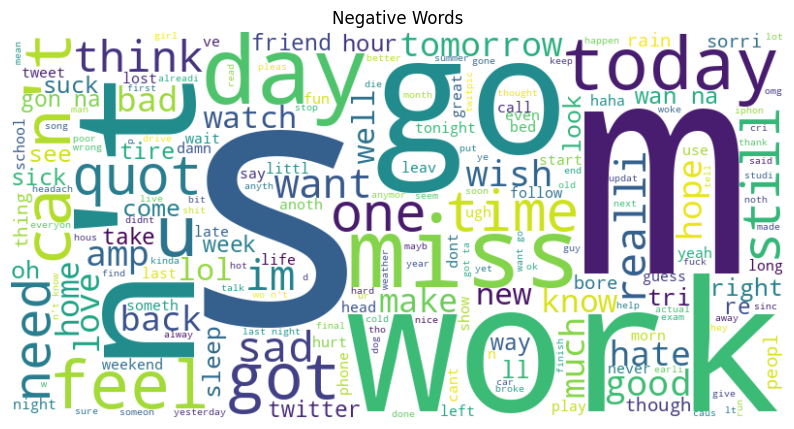

In [20]:
from wordcloud import WordCloud

positive_texts = data[data['sentiment'] == 'Positive']['text']
negative_texts = data[data['sentiment'] == 'Negative']['text']

def extract_words(sentiment_texts):
    all_words = []
    for text in sentiment_texts:
        words = word_tokenize(text)
        all_words.extend(words)
    return all_words

positive_words = extract_words(positive_texts)
negative_words = extract_words(negative_texts)


def create_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

create_word_cloud(positive_words, 'Positive Words')
create_word_cloud(negative_words, 'Negative Words')

**I'd like to point out that 'Work' is bigger in the negative words display than it is in the positive words one.**

## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [23]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)

(8000, 2)
(2000, 2)


**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(vocab_size)

13795


**Now transform the training and testing word sequences.**

In [25]:
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
print("Training Sequences:", train_sequences[0])
print("Testing Sequences:", test_sequences[0])

Training Sequences: [4181, 36, 307, 17, 6, 269, 2136, 903, 71, 545]
Testing Sequences: [340, 565, 1705, 2042, 110, 10]


**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [26]:
from keras.preprocessing.sequence import pad_sequences
max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
print("Training padded:", train_padded[0])
print("Testing padded:", test_padded[0])

Training padded: [4181   36  307   17    6  269 2136  903   71  545    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Testing padded: [ 340  565 1705 2042  110   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


**Label encode y.**

In [27]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['sentiment'])
test_labels = label_encoder.transform(test_data['sentiment'])
print("training labels: ",train_labels )
print("testing labels: ",test_labels )

training labels:  [1 0 0 ... 1 0 1]
testing labels:  [1 0 0 ... 1 0 1]


**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [28]:
import tensorflow as tf
import numpy as np
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-12-16 10:21:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-16 10:21:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-16 10:21:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [29]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length ,trainable=False)


Found 99390 word vectors.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previou code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [31]:
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(128, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 36)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 36, 300)           4053300   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 36, 300)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            96064     
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 512)               6604

**Train the model on the train split, and validate it on the test split.**

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5630 - loss: 0.6771
Epoch 1: val_loss improved from inf to 0.59174, saving model to model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.5633 - loss: 0.6769 - val_accuracy: 0.6756 - val_loss: 0.5917
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6874 - loss: 0.5949
Epoch 2: val_loss improved from 0.59174 to 0.57557, saving model to model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6874 - loss: 0.5949 - val_accuracy: 0.6844 - val_loss: 0.5756
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7390 - loss: 0.5311
Epoch 3: val_loss improved from 0.57557 to 0.56876, saving model to model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.7390 - loss: 0.5311 - val_accuracy: 0.6938 - val_loss: 0.5688
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7834 - loss: 0.4719
Epoch 4: val_loss did not improve from 0.56876
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.7834 - loss: 0.4719 - val_accuracy: 0.6988 - val_loss: 0.6072
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8435 - loss: 0.3689
Epoch 5: val_loss did not improve from 0.56876
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.8435 - loss: 0.3689 - val_accuracy: 0.6850 - val_loss: 0.6983
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8912 - loss: 0.2689
Epoch 6: val_loss did not improve from 0.56876
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.8912 - loss: 0.2689 - val_accuracy: 0.6812 - val_loss: 0.7856
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9239 - loss: 0.2110
Epoch 7: val_loss did not improv

**Let's visualise the model's training history now.**

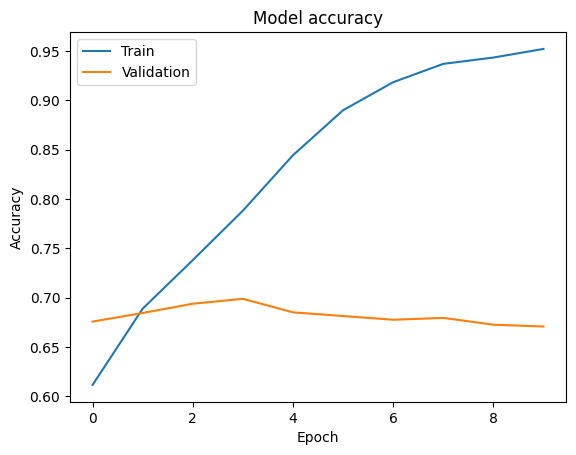

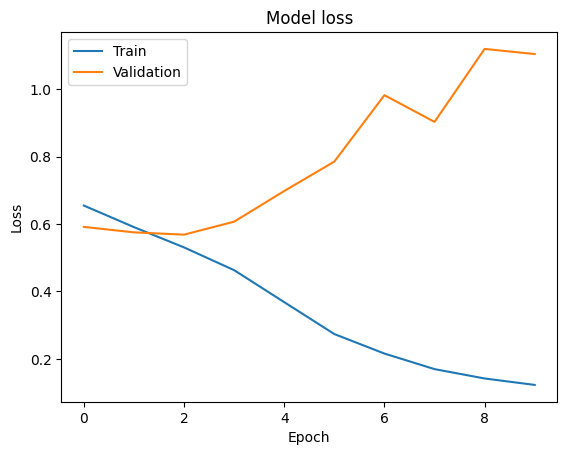

In [33]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Lets see what the accuracy of the model is.**

In [34]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6808 - loss: 1.0800
Test Loss: 1.0809870958328247
Test Accuracy: 0.6710000038146973


**We can try this on a random string as well.**

In [36]:
input_str="I love everyone on earth!"
def predict_sentiment(sequence):
 input=remove_stopwords(sequence)
 input=clean_text(sequence)
 input=clean_text_stem(sequence)
 input_sequence = tokenizer.texts_to_sequences([input])
 input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')
 return model.predict(input_padded)

def decode_sentiment(sentiment):
    if sentiment >= 0.5:
        return "Positive"
    else:
        return "Negative"

predicted_sentiment = decode_sentiment(predict_sentiment(input_str))

print("\nPredicted Sentiment:")
print(predicted_sentiment)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step

Predicted Sentiment:
Positive


After removal of stopwords: 0    I hate everyone earth!
dtype: object
After removal of punctuation: 0    I hate everyone earth 
dtype: object
After stemming: 0    i hate everyone earth 
dtype: object
After tokenization: [[1, 100, 138, 2693]]
After padding: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    1  100  138 2693]]
1/1 [==============================] - 0s 58ms/step
The predicted sentiment is: ['Negative']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## GOOD JOB!